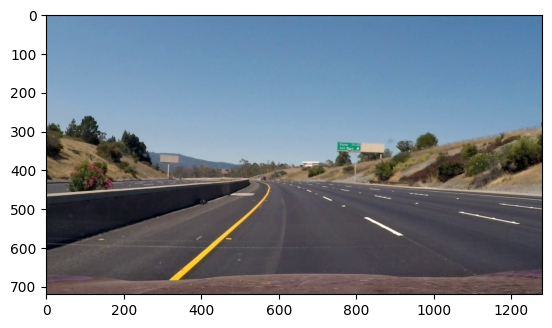

In [92]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# img=cv2.imread('1.jpg')
img = cv2.imread('frame.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# 使用matplotlib显示图片
plt.imshow(img)

In [ ]:
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')

In [ ]:
low_threshold = 40
high_threshold = 150
canny_image = cv2.Canny(gray, low_threshold, high_threshold)
plt.imshow(canny_image,cmap='gray')

In [4]:
def region_of_interest(img, vertices):
    #定义一个和输入图像同样大小的全黑图像mask，这个mask也称掩膜
    #掩膜的介绍，可参考：https://www.cnblogs.com/skyfsm/p/6894685.html
    mask = np.zeros_like(img)   
 
    #根据输入图像的通道数，忽略的像素点是多通道的白色，还是单通道的白色
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255


    #[vertices]中的点组成了多边形，将在多边形内的mask像素点保留，
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
 
    #与mask做"与"操作，即仅留下多边形部分的图像
    masked_image = cv2.bitwise_and(img, mask)


    return masked_image

In [ ]:
left_bottom = [0, canny_image .shape[0]]
right_bottom = [canny_image .shape[1], canny_image .shape[0]]
apex = [canny_image .shape[1]/2, 310]
vertices = np.array([ left_bottom, right_bottom, apex ], np.int32)
roi_image = region_of_interest(canny_image, vertices)
plt.imshow(roi_image,cmap='gray')

In [6]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
# Hough Transform 检测线段，线段两个端点的坐标存在lines中
lines = cv2.HoughLinesP(roi_image, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

In [9]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness) # 将线段绘制在img上

In [ ]:
import numpy as np
line_image = np.copy(img) # 复制一份原图，将线段绘制在这幅图上
print(lines.shape)
draw_lines(line_image, lines, [255, 0, 0], 6)
plt.imshow(line_image)

In [7]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    left_lines_x = []
    left_lines_y = []
    right_lines_x = []
    right_lines_y = []
    line_y_max = 0
    line_y_min = 999
    for line in lines:
        for x1,y1,x2,y2 in line:
            if y1 > line_y_max:
                line_y_max = y1
            if y2 > line_y_max:
                line_y_max = y2
            if y1 < line_y_min:
                line_y_min = y1
            if y2 < line_y_min:
                line_y_min = y2
            k = (y2 - y1)/(x2 - x1)
            if k < -0.3:
                left_lines_x.append(x1)
                left_lines_y.append(y1)
                left_lines_x.append(x2)
                left_lines_y.append(y2)
            elif k > 0.3:
                right_lines_x.append(x1)
                right_lines_y.append(y1)
                right_lines_x.append(x2)
                right_lines_y.append(y2)
    #最小二乘直线拟合
    left_line_k, left_line_b = np.polyfit(left_lines_x, left_lines_y, 1)
    right_line_k, right_line_b = np.polyfit(right_lines_x, right_lines_y, 1)
 
    #根据直线方程和最大、最小的y值反算对应的x
    cv2.line(img,
             (int((line_y_max - left_line_b)/left_line_k), line_y_max),
             (int((line_y_min - left_line_b)/left_line_k), line_y_min),
             color, thickness)
    cv2.line(img,
             (int((line_y_max - right_line_b)/right_line_k), line_y_max),
             (int((line_y_min - right_line_b)/right_line_k), line_y_min),
             color, thickness)

In [ ]:
import numpy as np
line_image = np.copy(img) # 复制一份原图，将线段绘制在这幅图上
draw_lines(line_image, lines, [255, 0, 0], 6)
plt.imshow(line_image)

In [ ]:
# img=cv2.imread('1.jpg')
img=cv2.imread('2.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# 使用matplotlib显示图片
plt.imshow(img)

In [121]:
# ⻋道线提取代码
def pipeline(img, s_thresh=(170, 255), sx_thresh=(40, 200)):
  img = np.copy(img)
  #1.将图像转换为HLS⾊彩空间，并分离各个通道
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
  h_channel = hls[:, :, 0]
  l_channel = hls[:, :, 1]
  s_channel = hls[:, :, 2]
  #2.利⽤sobel计算x⽅向的梯度
  sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
  abs_sobelx = np.absolute(sobelx) 
  # 将导数转换为8bit整数
  scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
  sxbinary = np.zeros_like(scaled_sobel)
  sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])]
  # 3.对s通道进⾏阈值处理
  s_binary = np.zeros_like(s_channel)
  s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
  # 4. 将边缘检测的结果和颜⾊空间阈值的结果合并，并结合l通道的取值，确定⻋道提取的⼆值图结
  color_binary = np.zeros_like(sxbinary)
  color_binary[((sxbinary == 1) | (s_binary == 1)) & (l_channel > 100)] = 1
  return color_binary

In [ ]:
img2 = pipeline(img, s_thresh=(30, 255), sx_thresh=(40, 200))
plt.imshow(img2, cmap='gray')

In [134]:
def cal_perspective_params(img, points):
  offset_x = 220
  # offset_x = 0
  offset_y = 0
  img_size = (img.shape[1], img.shape[0])
  src = np.float32(points)
  # 俯视图中四点的位置
  
  dst = np.float32([
    [offset_x, offset_y], 
    [img_size[0] - offset_x, offset_y],
    [offset_x, img_size[1] - offset_y], 
    [img_size[0] - offset_x, img_size[1] - offset_y]
  ])

  # 从原始图像转换为俯视图的透视变换的参数矩阵
  M = cv2.getPerspectiveTransform(src, dst)
  # 从俯视图转换为原始图像的透视变换参数矩阵
  M_inverse = cv2.getPerspectiveTransform(dst, src)
  return M, M_inverse


def img_perspect_transform(img, M):
  img_size = (img.shape[1], img.shape[0])
  return cv2.warpPerspective(img, M, img_size)


In [ ]:
# img = cv2.imread("1.jpg")
gray_copy = img2.copy()
print(gray_copy.shape)
points = [[603, 441], [681, 441], [218, 720], [1109, 720]]
# gray_copy = cv2.line(gray_copy, (386, 371), (581, 371), 1, 3)
# gray_copy = cv2.line(gray_copy, (581, 371), (850, 537), 1, 3)
# gray_copy = cv2.line(gray_copy, (850, 537), (146, 537), 1, 3)
# gray_copy = cv2.line(gray_copy, (146, 537), (386, 371), 1, 3)
M, M_inverse = cal_perspective_params(gray_copy, points)
print(M)
print(M_inverse)
transform_img = img_perspect_transform(gray_copy, M)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('原始图像')
plt.imshow(gray_copy, cmap='gray')
plt.subplot(1,2,2)
plt.title('俯视图')
plt.imshow(transform_img, cmap='gray')
plt.show()

In [136]:
def cal_line_param(binary_warped):
  # 1.确定左右⻋道线的位置
  # 统计直⽅图
  histogram = np.sum(binary_warped[:, :], axis=0)
  # 在统计结果中找到左右最⼤的点的位置，作为左右⻋道检测的开始点
  # 将统计结果⼀分为⼆，划分为左右两个部分，分别定位峰值位置，即为两条⻋道的搜索位置
  midpoint = np.int(histogram.shape[0] / 2)
  leftx_base = np.argmax(histogram[:midpoint])
  rightx_base = np.argmax(histogram[midpoint:]) + midpoint
  # 2.滑动窗⼝检测⻋道线
  # 设置滑动窗⼝的数量，计算每⼀个窗⼝的⾼度
  nwindows = 9
  window_height = np.int(binary_warped.shape[0] / nwindows)
  # 获取图像中不为0的点
  nonzero = binary_warped.nonzero()
  nonzeroy = np.array(nonzero[0])
  nonzerox = np.array(nonzero[1])
  # ⻋道检测的当前位置
  leftx_current = leftx_base
  rightx_current = rightx_base
  # 设置x的检测范围，滑动窗⼝的宽度的⼀半，⼿动指定
  margin = 100
  # 设置最⼩像素点，阈值⽤于统计滑动窗⼝区域内的⾮零像素个数，⼩于50的窗⼝不对x的中⼼值进⾏
  minpix = 50
  # ⽤来记录搜索窗⼝中⾮零点在nonzeroy和nonzerox中的索引
  left_lane_inds = []
  right_lane_inds = []
  # 遍历该副图像中的每⼀个窗⼝
  for window in range(nwindows):
    # 设置窗⼝的y的检测范围，因为图像是（⾏列）,shape[0]表示y⽅向的结果，上⾯是0
    win_y_low = binary_warped.shape[0] - (window + 1) * window_height
    win_y_high = binary_warped.shape[0] - window * window_height
    # 左⻋道x的范围
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    # 右⻋道x的范围
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # 确定⾮零点的位置x,y是否在搜索窗⼝中，将在搜索窗⼝内的x,y的索引存⼊left_lane_ind
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high))
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
      (nonzerox >= win_xright_low) & (nonzerox < win_xright_high))
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # 如果获取的点的个数⼤于最⼩个数，则利⽤其更新滑动窗⼝在x轴的位置
    if np.sum(good_left_inds) > minpix:
      leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if np.sum(good_right_inds) > minpix:
      rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
  
  # 将left_lane_inds 中的数组进行 logical_or 操作，将⾮零点的索引取出
  # 创建一个全为Falsed的数组，数组的⻓度为nonzerox的⻓度
  left_lane_inds1 = np.zeros_like(nonzerox)
  right_lane_inds1 = np.zeros_like(nonzerox)
  for i in range(len(left_lane_inds)):
    left_lane_inds1 = np.logical_or(left_lane_inds1, left_lane_inds[i])
  for i in range(len(right_lane_inds)):
    right_lane_inds1 = np.logical_or(right_lane_inds1, right_lane_inds[i])

  # 获取检测出的左右⻋道点在图像中的位置
  leftx = nonzerox[left_lane_inds1]
  lefty = nonzeroy[left_lane_inds1]
  rightx = nonzerox[right_lane_inds1]
  righty = nonzeroy[right_lane_inds1]

  # 3.⽤曲线拟合检测出的点,⼆次多项式拟合，返回的结果是系数
  left_fit = np.polyfit(lefty, leftx, 2)
  right_fit = np.polyfit(righty, rightx, 2)
  return left_fit, right_fit


In [137]:
left_fit, right_fit = cal_line_param(transform_img)

C:\Users\chaisen\AppData\Local\Temp\ipykernel_4900\2688610881.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
C:\Users\chaisen\AppData\Local\Temp\ipykernel_4900\2688610881.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rel

In [138]:
def fill_lane_poly(img, left_fit, right_fit):
  # 获取图像的⾏数
  y_max = img.shape[0]
  # 设置输出图像的⼤⼩，并将⽩⾊位置设为255
  out_img = np.dstack((img, img, img)) * 255
  # 在拟合曲线中获取左右⻋道线的像素位置
  left_points = [[left_fit[0] * y ** 2 + left_fit[1] * y + left_fit[2], y] for y in range(y_max)]
  right_points = [[right_fit[0] * y ** 2 + right_fit[1] * y + right_fit[2], y] for y in range(y_max -1, -1, -1)]
  # 将左右⻋道的像素点进⾏合并
  line_points = np.vstack((left_points, right_points))
  # 根据左右⻋道线的像素位置绘制多边形
  cv2.fillPoly(out_img, np.int_([line_points]), (0, 255, 0))
  return out_img

In [ ]:
fill_img = fill_lane_poly(transform_img, left_fit, right_fit)
plt.imshow(fill_img)

In [ ]:
transform_img_inverse = img_perspect_transform(fill_img, M_inverse)
plt.imshow(transform_img_inverse)

In [ ]:
transform_img_inverse = cv2.addWeighted(img, 1, transform_img_inverse, 0.3, 0)
plt.imshow(transform_img_inverse)

In [145]:
def cal_radius(img, left_fit, right_fit):
  # 图像中像素个数与实际中距离的⽐率
  # 沿⻋⾏进的⽅向⻓度⼤概覆盖了30⽶，按照美国⾼速公路的标准，宽度为3.7⽶（经验值）
  ym_per_pix = 30 / 720 # y⽅向像素个数与距离的⽐例
  xm_per_pix = 3.7 / 700 # x⽅向像素个数与距离的⽐例
  # 计算得到曲线上的每个点
  left_y_axis = np.linspace(0, img.shape[0], img.shape[0] - 1)
  left_x_axis = left_fit[0] * left_y_axis ** 2 + left_fit[1] * left_y_axis + left_fit[2]
  right_y_axis = np.linspace(0, img.shape[0], img.shape[0] - 1)
  right_x_axis = right_fit[0] * right_y_axis ** 2 + right_fit[1] * right_y_axis + right_fit[2]
  # 获取真实环境中的曲线
  left_fit_cr = np.polyfit(left_y_axis * ym_per_pix, left_x_axis * xm_per_pix, 2)
  right_fit_cr = np.polyfit(right_y_axis * ym_per_pix, right_x_axis * xm_per_pix, 2)
  
  # 获得真实环境中的曲线曲率
  left_curverad = ((1 + (2 * left_fit_cr[0] * left_y_axis * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute( 2 * left_fit_cr[0])
  right_curverad = ((1 + (2 * right_fit_cr[0] * right_y_axis * ym_per_pix + right_fit_cr[1]) **2) ** 1.5) / np.absolute( 2 * right_fit_cr[0])
  # 在图像上显示曲率
  cv2.putText(img, 'Radius of Curvature = {}(m)'.format(np.mean(left_curverad)), (20, 50), cv2.FONT_ITALIC, 1, (255, 255, 255), 5)
  return img

In [ ]:
cal_radius(img, left_fit, right_fit)
plt.imshow(img)

left_fit =  [ 2.09991311e-04 -3.00070148e-01  3.27641630e+02]
right_fit =  [ 1.04955208e-04 -3.22614332e-02  1.03039048e+03]
⻋道的中⼼点为：641.0108260215163


C:\Users\chaisen\AppData\Local\Temp\ipykernel_4900\254156970.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
C:\Users\chaisen\AppData\Local\Temp\ipykernel_4900\2688610881.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: ht

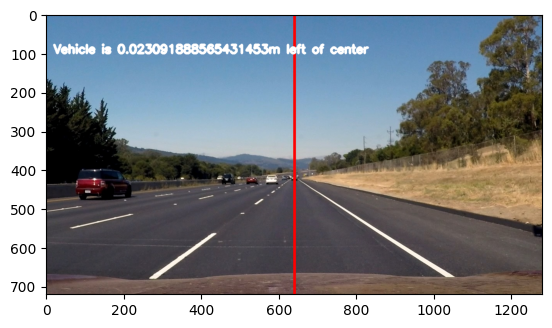

In [153]:
# img = cv2.imread('2.jpg')

# 1. 定义函数计算图像的中⼼点位置
def cal_line_center(img):
  # undistort_img = img_undistort(img, mtx, dist)
  rigin_pipline_img = pipeline(img)
  transform_img = img_perspect_transform(rigin_pipline_img, M)
  left_fit, right_fit = cal_line_param(transform_img)
  print('left_fit = ', left_fit)
  print('right_fit = ', right_fit)
  
  y_max = img.shape[0]
  # img最底部的两个点的横坐标
  left_x = left_fit[0] * y_max ** 2 + left_fit[1] * y_max + left_fit[2]
  right_x = right_fit[0] * y_max ** 2 + right_fit[1] * y_max + right_fit[2]
  return (left_x + right_x) / 2
# 2. 假设straight_lines2_line.jpg，这张图⽚是位于⻋道的中央，实际情况可以根据测量验证.
img =cv2.imread("2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lane_center = cal_line_center(img)
print("⻋道的中⼼点为：{}".format(lane_center))
# 在 img 中画出⻋道的中⼼点的竖线
cv2.line(img, (int(lane_center), 0), (int(lane_center), img.shape[0]), (255, 0, 0), 5)
plt.imshow(img)
# 3. 计算偏离中⼼的距离
def cal_center_departure(img, left_fit, right_fit):
  # 计算中⼼点
  y_max = img.shape[0]
  left_x = left_fit[0] * y_max ** 2 + left_fit[1] * y_max + left_fit[2]
  right_x = right_fit[0] * y_max ** 2 + right_fit[1] * y_max + right_fit[2]
  xm_per_pix = 3.7 / 700
  center_depart = ((left_x + right_x) / 2 - lane_center) * xm_per_pix
  # 在图像上显示偏移
  if center_depart > 0:
    cv2.putText(img, 'Vehicle is {}m right of center'.format(center_depart), (20, 100), cv2.FONT_ITALIC, 1,
  (255, 255, 255), 5)
  elif center_depart < 0:
    cv2.putText(img, 'Vehicle is {}m left of center'.format(-center_depart), (20, 100), cv2.FONT_ITALIC, 1,
  (255, 255, 255), 5)
  else:
    cv2.putText(img, 'Vehicle is in the center', (20, 100), cv2.FONT_ITALIC, 1, (255, 255, 255), 5)
  return img

cal_center_departure(img, left_fit, right_fit)
plt.imshow(img)